# Learning the Embedding with the use of Neural Networks
We'll use Neural Collaborative Filtering (https://arxiv.org/pdf/1708.05031.pdf) to create a NN that learns the embedding of the data

## Necessary imports

In [1]:
import pandas as pd
import re
import numpy as np
from datetime import datetime
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for machine learning
from sklearn import preprocessing, metrics

## Importing the data

In [2]:
movies = pd.read_excel('data/movie_e.xlsx')

In [3]:
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
27273   131254       Kein Bund fÃ¼r's Leben (2007)   
27274   131256       Feuer, Eis & Dosenbier (2002)   
27275   131258                  The Pirates (2014)   
27276   131260                 Rentun Ruusu (2001)   
27277   131262                    Innocence (2014)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
27273                                       Comedy  
27274                                       Comedy  
27275                                    Adventure  
27276                           (no genres listed)  
27277                     Adventure|Fantasy|Horror  

[27278 rows x 3 columns]

In [4]:
user_rating = pd.read_csv('data/rating.csv')

In [5]:
user_rating

userId  movieId  rating            timestamp
0              1        2     3.5  2005-04-02 23:53:47
1              1       29     3.5  2005-04-02 23:31:16
2              1       32     3.5  2005-04-02 23:33:39
3              1       47     3.5  2005-04-02 23:32:07
4              1       50     3.5  2005-04-02 23:29:40
...          ...      ...     ...                  ...
20000258  138493    68954     4.5  2009-11-13 15:42:00
20000259  138493    69526     4.5  2009-12-03 18:31:48
20000260  138493    69644     3.0  2009-12-07 18:10:57
20000261  138493    70286     5.0  2009-11-13 15:42:24
20000262  138493    71619     2.5  2009-10-17 20:25:36

[20000263 rows x 4 columns]

#### Prepare movies data:

In [6]:
movies = movies[~movies["genres"].isna()]
movies["entry_id"] = range(0, len(movies))
regexp = re.compile(r'[(]\d*?[)]') # mathces (number)

# remove the release year of movies, and save it in another column
movies["movie_name"] = movies["title"].apply(lambda x:
                                             re.sub(regexp, "", x).strip())
# print(movies.loc[15646])
# get the release year and save it in another column

movies["date"] = movies["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").replace("\"", "").strip()) if regexp.search(x) else np.nan)

movies["date"] = movies["date"].fillna(9999)
movies["old"] = movies["date"].apply(lambda x: 1 if x < 2000 else 0)

In [7]:
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
27273   131254       Kein Bund fÃ¼r's Leben (2007)   
27274   131256       Feuer, Eis & Dosenbier (2002)   
27275   131258                  The Pirates (2014)   
27276   131260                 Rentun Ruusu (2001)   
27277   131262                    Innocence (2014)   

                                            genres  entry_id  \
0      Adventure|Animation|Children|Comedy|Fantasy         0   
1                       Adventure|Children|Fantasy         1   
2                                   Comedy|Romance         2   
3                             Comedy|Drama|Romance         3   
4                                           Comedy         4   
...                                            ...       ...   
27273                                       Comedy     27273   
27274                                       Comedy     27274   
27275                                    Adventure     27275   
27276                           (no genres listed)     27276   
27277                     Adventure|Fantasy|Horror     27277   

                        movie_name    date  old  
0                        Toy Story  1995.0    1  
1                          Jumanji  1995.0    1  
2                 Grumpier Old Men  1995.0    1  
3                Waiting to Exhale  1995.0    1  
4      Father of the Bride Part II  1995.0    1  
...                            ...     ...  ...  
27273       Kein Bund fÃ¼r's Leben  2007.0    0  
27274       Feuer, Eis & Dosenbier  2002.0    0  
27275                  The Pirates  2014.0    0  
27276                 Rentun Ruusu  2001.0    0  
27277                    Innocence  2014.0    0  

[27278 rows x 7 columns]

#### Prepare user-rating data:

In [8]:
user_rating["user"] = user_rating["userId"].apply(lambda x: x-1)
# FOR CONTEXT_BASED:
# user_rating["timestamp"] = user_rating["timestamp"].apply(lambda x: datetime.fromtimestamp(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
# user_rating["daytime"] = user_rating["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
# user_rating["weekend"] = user_rating["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)
user_rating = user_rating.merge(movies[["movieId","entry_id"]], how="left")
user_rating = user_rating.rename(columns={"rating":"y"})

In [9]:
movies = movies[["entry_id", "movie_name", "old", "genres"]].set_index("entry_id")
user_rating = user_rating[["user", "entry_id", "timestamp", "y"]]

In [10]:
user_rating

user  entry_id            timestamp    y
0              0         1  2005-04-02 23:53:47  3.5
1              0        28  2005-04-02 23:31:16  3.5
2              0        31  2005-04-02 23:33:39  3.5
3              0        46  2005-04-02 23:32:07  3.5
4              0        49  2005-04-02 23:29:40  3.5
...          ...       ...                  ...  ...
20000258  138492     13767  2009-11-13 15:42:00  4.5
20000259  138492     13876  2009-12-03 18:31:48  4.5
20000260  138492     13890  2009-12-07 18:10:57  3.0
20000261  138492     14009  2009-11-13 15:42:24  5.0
20000262  138492     14293  2009-10-17 20:25:36  2.5

[20000263 rows x 4 columns]

In [11]:
movies

movie_name  old  \
entry_id                                     
0                           Toy Story    1   
1                             Jumanji    1   
2                    Grumpier Old Men    1   
3                   Waiting to Exhale    1   
4         Father of the Bride Part II    1   
...                               ...  ...   
27273          Kein Bund fÃ¼r's Leben    0   
27274          Feuer, Eis & Dosenbier    0   
27275                     The Pirates    0   
27276                    Rentun Ruusu    0   
27277                       Innocence    0   

                                               genres  
entry_id                                               
0         Adventure|Animation|Children|Comedy|Fantasy  
1                          Adventure|Children|Fantasy  
2                                      Comedy|Romance  
3                                Comedy|Drama|Romance  
4                                              Comedy  
...                                               ...  
27273                                          Comedy  
27274                                          Comedy  
27275                                       Adventure  
27276                              (no genres listed)  
27277                        Adventure|Fantasy|Horror  

[27278 rows x 3 columns]

#### product-feature matrix:

In [12]:
tags = [i.split("|") for i in movies["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
for col in columns:
    movies[col] = movies["genres"].apply(lambda x: 1 if col in x else 0)

In [13]:
movies

movie_name  old  \
entry_id                                     
0                           Toy Story    1   
1                             Jumanji    1   
2                    Grumpier Old Men    1   
3                   Waiting to Exhale    1   
4         Father of the Bride Part II    1   
...                               ...  ...   
27273          Kein Bund fÃ¼r's Leben    0   
27274          Feuer, Eis & Dosenbier    0   
27275                     The Pirates    0   
27276                    Rentun Ruusu    0   
27277                       Innocence    0   

                                               genres  Comedy  Animation  \
entry_id                                                                   
0         Adventure|Animation|Children|Comedy|Fantasy       1          1   
1                          Adventure|Children|Fantasy       0          0   
2                                      Comedy|Romance       1          0   
3                                Comedy|Drama|Romance       1          0   
4                                              Comedy       1          0   
...                                               ...     ...        ...   
27273                                          Comedy       1          0   
27274                                          Comedy       1          0   
27275                                       Adventure       0          0   
27276                              (no genres listed)       0          0   
27277                        Adventure|Fantasy|Horror       0          0   

          Drama  Sci-Fi  Horror  Action  Western  ...  Documentary  Thriller  \
entry_id                                          ...                          
0             0       0       0       0        0  ...            0         0   
1             0       0       0       0        0  ...            0         0   
2             0       0       0       0        0  ...            0         0   
3             1       0       0       0        0  ...            0         0   
4             0       0       0       0        0  ...            0         0   
...         ...     ...     ...     ...      ...  ...          ...       ...   
27273         0       0       0       0        0  ...            0         0   
27274         0       0       0       0        0  ...            0         0   
27275         0       0       0       0        0  ...            0         0   
27276         0       0       0       0        0  ...            0         0   
27277         0       0       1       0        0  ...            0         0   

          Romance  Fantasy  Mystery  Adventure  Children  IMAX  Musical  \
entry_id                                                                  
0               0        1        0          1         1     0        0   
1               0        1        0          1         1     0        0   
2               1        0        0          0         0     0        0   
3               1        0        0          0         0     0        0   
4               0        0        0          0         0     0        0   
...           ...      ...      ...        ...       ...   ...      ...   
27273           0        0        0          0         0     0        0   
27274           0        0        0          0         0     0        0   
27275           0        0        0          1         0     0        0   
27276           0        0        0          0         0     0        0   
27277           0        1        0          1         0     0        0   

          Film-Noir  
entry_id             
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
27273             0  
27274             0  
27275             0  
27276             0  
27277             0  

[27278 rows x 22 columns]

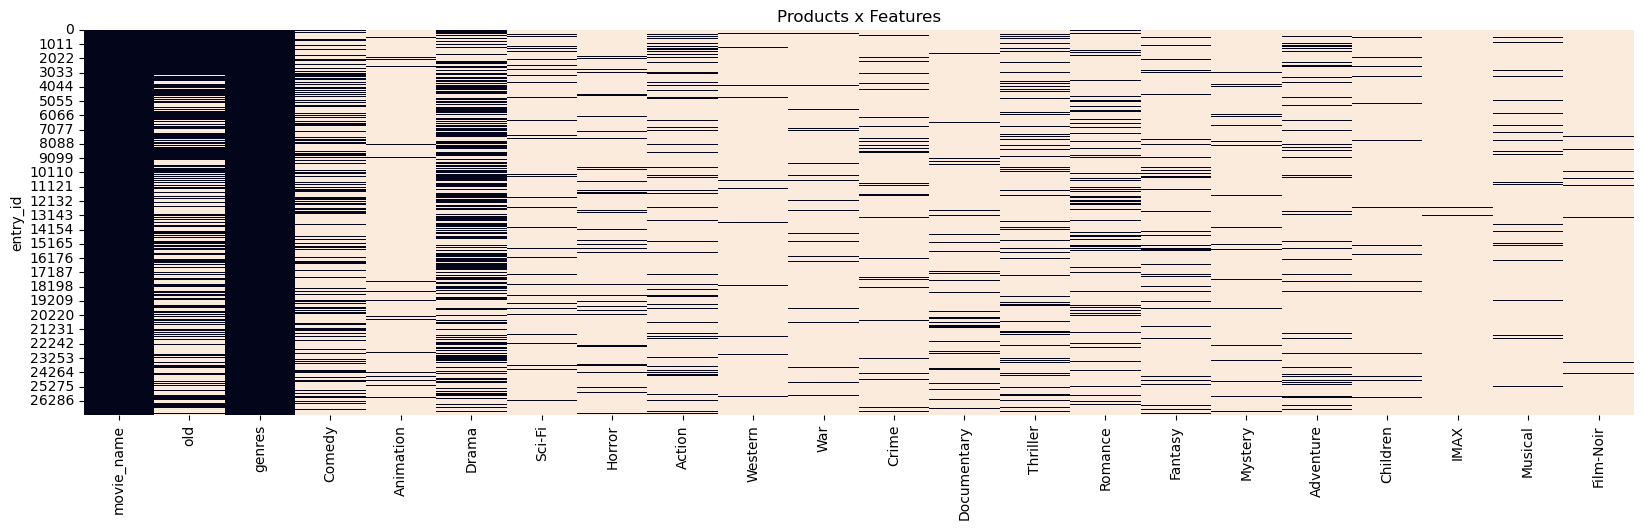

In [14]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(movies==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

In [15]:
user_rating

user  entry_id            timestamp    y
0              0         1  2005-04-02 23:53:47  3.5
1              0        28  2005-04-02 23:31:16  3.5
2              0        31  2005-04-02 23:33:39  3.5
3              0        46  2005-04-02 23:32:07  3.5
4              0        49  2005-04-02 23:29:40  3.5
...          ...       ...                  ...  ...
20000258  138492     13767  2009-11-13 15:42:00  4.5
20000259  138492     13876  2009-12-03 18:31:48  4.5
20000260  138492     13890  2009-12-07 18:10:57  3.0
20000261  138492     14009  2009-11-13 15:42:24  5.0
20000262  138492     14293  2009-10-17 20:25:36  2.5

[20000263 rows x 4 columns]

In [ ]:
tmp = user_rating.copy()
tmp = tmp.head(10000) #< heap memory exceded otherwise
user_rating = tmp.pivot_table(index="user", columns="entry_id", values="y")
missing_cols = list(set(movies.index) - set(user_rating.columns))
for col in missing_cols:
    user_rating[col] = np.nan
user_rating = user_rating[sorted(user_rating.columns)]

C:\Users\sorana\AppData\Local\Temp\ipykernel_16124\84046471.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_rating[col] = np.nan
C:\Users\sorana\AppData\Local\Temp\ipykernel_16124\84046471.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_rating[col] = np.nan
C:\Users\sorana\AppData\Local\Temp\ipykernel_16124\84046471.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(user_rating.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("User x Products")
plt.show()

# Preprocess data

In [ ]:
user_rating = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(user_rating.values), 
                         columns=user_rating.columns, index=user_rating.index)

In [ ]:
user_rating

In [ ]:
split = int(0.8*user_rating.shape[1])
split


In [ ]:
# Train
train_users = user_rating.loc[:, :split-1]
print("non-null data:", train_users[train_users>0].count().sum())
train_users

In [ ]:
# Test
test_user = user_rating.loc[:, split:]
print("non-null data:", test_user[test_user>0].count().sum())
test_user


# Neural Network

### Needed imports:

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.layers import Input, Embedding, Dot, Dense, Reshape
from tensorflow.keras import Model, utils

### Training parameters:

In [ ]:
embeding_size = 50
user_max, movie_max = user_rating.shape[0], user_rating.shape[1]

In [ ]:
user_rating.shape

### Define the Model:

In [ ]:
# user embedding:
input_users = Input(name="user_inp", shape=(1,))
user_embedding = Embedding(name="user_emb", input_dim=user_max, output_dim=embeding_size)(input_users)
user_emb_r = Reshape(name='reshape_usr', target_shape=((embeding_size,)))(user_embedding)

In [ ]:
# movie embedding:
input_movie = Input(name="movie_inp", shape=(1,))
movie_embedding = Embedding(name="movie_emb", input_dim=movie_max, output_dim=embeding_size)(input_movie)
movie_emb_r = Reshape(name='reshape_movie', target_shape=((embeding_size,)))(movie_embedding)

In [ ]:
sim = Dot(name='dot', normalize=True, axes=1)([user_emb_r, movie_emb_r])

In [ ]:
y_out = layers.Dense(name="y_out", units=1, activation='linear')(sim)

In [ ]:
model = Model(inputs=[input_users,input_movie], outputs=y_out, name="CollaborativeFiltering")

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)